The goal of this notebook is to develop code to generate training data for training a UNet or similar. The code from here will then be adapted to some "production" code. 

The training data will look like this:

1. input: pair of images of 4xWxH from before and after
    - these can come from the 'before' and 'after' periods (ie. many possible combinations) or also from various mosaics of them
    - these will be merged in some way; the vanilla merge method is concat; better methods can include trainable merge
    - later it can be more than 2 images, e.g. it can be 3 from each before and after 
2. label: image of 1xWxH with binary label - deforestation or not for a particular date (as per the DETER polygon specified date)
    - this will be created by rasterization of DETER polygons, either a single one or multiple grouped by e.g. week or month


In [108]:
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd

In [9]:
raster_paths = '../data/aoi_1/raster/2019_2021'
deter_path = '../data/sample_data/DETER/deter_public.shp'
aoi_path = '../data/aoi_1/vector/aoi_1.geojson'

In [29]:
deter = gpd.read_file(deter_path)
aoi = gpd.read_file(aoi_path).to_crs(deter.crs)
deter_aoi = gpd.clip(deter, aoi)
deter_aoi['date'] = deter_aoi["VIEW_DATE"].astype("datetime64")

In [52]:
deter_aoi_2019_21 = deter_aoi[(deter_aoi['date'] > "2019-01-01") & (deter_aoi['date'] < "2022-01-01")]
deter_aoi_2019_21

,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry,date
date,,,,,,,,,,,,,,
2021-10-03,DESMATAMENTO_CR,None,168105,2021-10-03,AWFI,CBERS-4,0.0,None,0.290930,Altamira,1500602,PA,"POLYGON ((-53.64143 -5.86984, -53.64900 -5.868...",2021-10-03
2021-10-05,DEGRADACAO,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,0.221640,Altamira,1500602,PA,"POLYGON ((-53.76300 -5.87785, -53.76271 -5.877...",2021-10-05
2021-07-06,DEGRADACAO,None,163111,2021-07-06,AWFI,CBERS-4,0.0,None,0.077628,Altamira,1500602,PA,"POLYGON ((-53.65610 -6.15209, -53.65584 -6.152...",2021-07-06
2021-10-05,DEGRADACAO,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,0.674434,Altamira,1500602,PA,"POLYGON ((-53.67105 -5.80741, -53.67088 -5.807...",2021-10-05
2021-10-05,DESMATAMENTO_CR,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,1.188350,Altamira,1500602,PA,"POLYGON ((-53.64364 -6.15132, -53.64339 -6.151...",2021-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-22,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.092532,Altamira,1500602,PA,"POLYGON ((-53.51657 -6.13940, -53.51679 -6.139...",2020-08-22
2020-08-22,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.090413,Altamira,1500602,PA,"POLYGON ((-53.51787 -6.18079, -53.51484 -6.182...",2020-08-22
2020-08-22,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.164874,Altamira,1500602,PA,"POLYGON ((-53.57832 -6.10408, -53.57751 -6.103...",2020-08-22


<AxesSubplot:xlabel='date'>

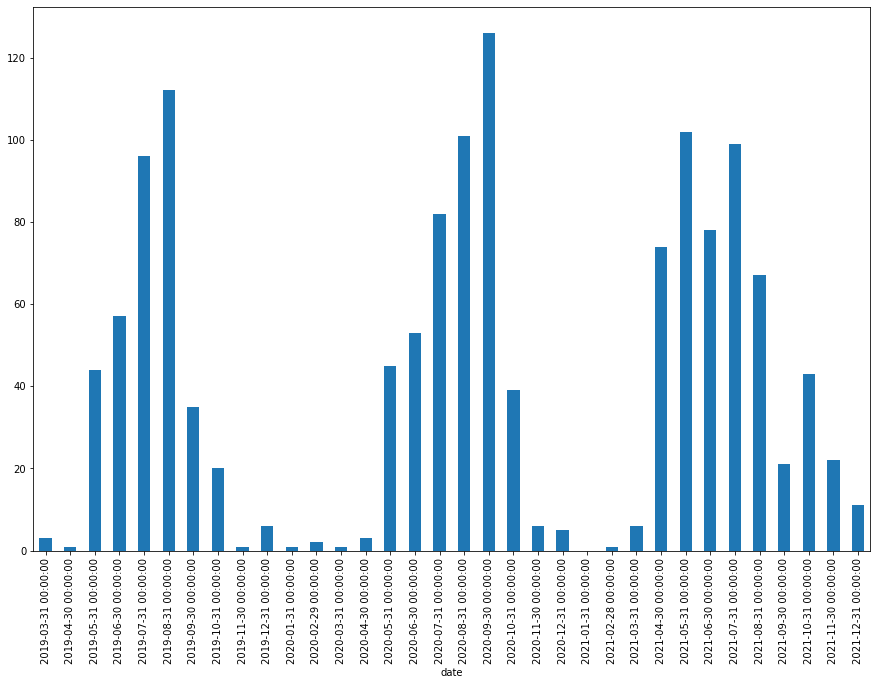

In [53]:
deter_aoi_2019_21.set_index('date', inplace=True)
deter_aoi_2019_21.resample('M').size().plot.bar(figsize=(15,10))


In [86]:
sample = deter_aoi_2019_21.iloc[11:12].reset_index()
sample

,date,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
0,2020-08-25,DESMATAMENTO_CR,None,164105,2020-08-25,AWFI,CBERS-4,0.0,None,0.179314,Altamira,1500602,PA,"POLYGON ((-53.39948 -6.05016, -53.40000 -6.052..."


In [71]:
name = os.listdir(raster_paths)[0].split(".")[0]

months_mapping = {"Jan" : "01",
                 "Feb" : "02",
                 "Mar" : "03",
                 "Apr" : "04",
                 "May" : "05",
                 "Jun" : "06",
                 "Jul" : "07",
                 "Aug" : "08",
                 "Sep" : "09",
                 "Oct" : "10",
                 "Nov" : "11",
                 "Dec" : "12"
                 }



print(name)

20210725


In [96]:
rasters = []

for file in os.listdir(raster_paths):
    if not file.endswith(".tif"):
        continue
    filename = Path(file).stem
    for key in months_mapping.keys():
        filename = filename.replace(key, months_mapping[key])
    date = pd.to_datetime(filename)
    filepath = os.path.join(raster_paths, file)
    rasters.append([date, filepath])


rasters_df = pd.DataFrame(rasters, columns=('date', 'path'))
rasters_df = rasters_df.sort_values(by='date')



In [104]:
sample.date.values[0]

numpy.datetime64('2020-08-25T00:00:00.000000000')

In [105]:
before = rasters_df[rasters_df.date < sample.date.values[0]]
after = rasters_df[rasters_df.date > sample.date.values[0]]


In [107]:
before[-1:].path
after[:1]

,date,path
224,2020-08-26,../data/aoi_1/raster/2019_2021/2020Aug26.tif


In [109]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = 0, 255
    return ((array - array_min)/(array_max - array_min))

'../data/aoi_1/raster/2019_2021/2020Aug24.tif'

In [115]:
with rasterio.open(before[-1:].path.values[0]) as src:

    # Read the grid values into numpy arrays
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    print("Normalized bands")
    print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
    print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
    print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))

    # Let's see how our color composite looks like
    plt.imshow(rgb)

Normalized bands
nan - nan mean: nan
nan - nan mean: nan
nan - nan mean: nan


NameError: name 'plt' is not defined